# DANN with autoencoder

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import torch.backends.cudnn as cudnn

from torch.autograd import Function

import matplotlib.pyplot as plt

import load_mnist_data
import data_visualization

### Base Line: DANN

In [3]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [4]:
class DANN(nn.Module):
    def __init__(self):
        super(DANN, self).__init__()
        self.feature = nn.Sequential(
                    nn.Conv2d(3, 64, kernel_size=5),
                    nn.BatchNorm2d(64),
                    nn.MaxPool2d(2),
                    nn.ReLU(True),
                    nn.Conv2d(64, 50, kernel_size=5),
                    nn.BatchNorm2d(50),
                    nn.Dropout2d(),
                    nn.MaxPool2d(2),
                    nn.ReLU(True)
                )
                
        self.avgpool=nn.AdaptiveAvgPool2d((5,5))
        self.classifier = nn.Sequential(
                    nn.Linear(50 * 4 * 4, 100),
                    nn.BatchNorm1d(100),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(100, 100),
                    nn.BatchNorm1d(100),
                    nn.ReLU(True),
                    nn.Linear(100, 10),
                )


        self.domain_classifier = nn.Sequential(
                    nn.Linear(50 * 4 * 4, 100),
                    nn.BatchNorm1d(100),
                    nn.ReLU(True),
                    nn.Linear(100, 2),
                )
    def forward(self, input_data, alpha):
        input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, 50 * 4 * 4)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output


In [5]:
def train(source, target, net, criterion, optimizer, epoch, use_cuda=True):
    net.train() # Sets the module in training mode.

    train_loss = 0
    correct_source_label = 0
    correct_source_domain = 0
    correct_target_label = 0
    correct_target_domain = 0
    total = 0
    batch_size = 128

    data_target_iter = iter(target)
    len_dataloader = min(len(source), len(target))

    for batch_idx, (inputs, source_label) in enumerate(source):

        p = float(batch_idx + epoch * len_dataloader) / (200 * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        batch_size = inputs.size(0)
        total += batch_size

        # Feed source image to the network
        source_label = source_label.type(torch.LongTensor)
        domain_label = torch.zeros(batch_size).long()

        if use_cuda:
            inputs, source_label, domain_label = inputs.cuda(), source_label.cuda(), domain_label.cuda()
            
        optimizer.zero_grad()
        inputs, source_label = Variable(inputs), Variable(source_label)
        
        class_output, domain_output = net(inputs, alpha)
        
        _, predicted = torch.max(class_output.data, 1)
        correct_source_label += predicted.eq(source_label.data).cpu().sum().item()
        _, predicted = torch.max(domain_output.data, 1)
        correct_source_domain += predicted.eq(domain_label.data).cpu().sum().item()

        loss_s_label = criterion(class_output, source_label)
        loss_s_domain = criterion(domain_output, domain_label)

        # Feed target image to the network
        target_inputs, target_label = data_target_iter.next()
        domain_label = torch.ones(batch_size).long()
        if use_cuda:
            target_inputs, target_label, domain_label = target_inputs.cuda(), target_label.cuda(), domain_label.cuda()
        
        class_output, domain_output = net(target_inputs, alpha)
        loss_t_domain = criterion(domain_output, domain_label)

        _, predicted = torch.max(class_output.data, 1)
        correct_target_label += predicted.eq(target_label.data).cpu().sum().item()
        _, predicted = torch.max(domain_output.data, 1)
        correct_target_domain += predicted.eq(domain_label.data).cpu().sum().item()

        loss = loss_s_label + loss_s_domain + loss_t_domain
        loss.backward()
        optimizer.step()
    
    return correct_source_label, correct_source_domain, correct_target_label, correct_target_domain, total


In [6]:
loader_source, loader_target = load_mnist_data.get_data_loader(1)

In [7]:
criterion = nn.CrossEntropyLoss()

net = DANN()
if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    net.cuda()
    criterion = criterion.cuda()
    
optimizer = optim.Adam(net.parameters(), lr=0.001) 

history_DANN = []
for epoch in range(0, 201):
    sl, sd, tl, td, total = train(loader_source, loader_target, net, criterion, optimizer, epoch) 
    history_DANN.append([sl/total, sd/total, tl/total, td/total])
    if (epoch % 20 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, sl/total, sd/total, tl/total, td/total))

e: 0, sl: 0.825350, sd: 0.796167, tl: 0.375667, td: 0.770317
e: 20, sl: 0.936700, sd: 0.688317, tl: 0.648383, td: 0.680850
e: 40, sl: 0.937467, sd: 0.642150, tl: 0.703600, td: 0.641683
e: 60, sl: 0.941617, sd: 0.631067, tl: 0.731117, td: 0.627300
e: 80, sl: 0.946800, sd: 0.627617, tl: 0.744900, td: 0.620583
e: 100, sl: 0.949483, sd: 0.620117, tl: 0.756933, td: 0.614267
e: 120, sl: 0.952333, sd: 0.617067, tl: 0.771900, td: 0.611917
e: 140, sl: 0.954500, sd: 0.617950, tl: 0.771200, td: 0.611733
e: 160, sl: 0.955333, sd: 0.618467, tl: 0.778067, td: 0.607550
e: 180, sl: 0.957583, sd: 0.613650, tl: 0.777800, td: 0.609233
e: 200, sl: 0.960867, sd: 0.612233, tl: 0.783550, td: 0.606267


### First Attempt: Follow the instruction of the paper

In [8]:
class DANN_with_autoencoder(nn.Module):
    def __init__(self):
        super(DANN_with_autoencoder, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(50, 64, 5, stride=2, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, 5, stride=2, output_padding=1),
            nn.InstanceNorm2d(3),
            nn.ReLU(inplace=True),

            nn.Tanh()
        )
    
        self.classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 4* 4, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
        )
        
    def forward(self, input_data, alpha):
            input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
            feature = self.feature(input_data)

            reconstructed_data = self.decoder(feature)
            feature = feature.view(-1, 50 * 4 * 4)
            reverse_feature = ReverseLayerF.apply(feature, alpha)
            class_output = self.classifier(feature)
            domain_output = self.domain_classifier(reverse_feature)

            return class_output, domain_output, reconstructed_data

In [9]:
def train_with_autoencoder(source, target, net, criterion,criterion_construct, optimizer, use_cuda, epoch):
    net.train() # Sets the module in training mode.
    total = 0
    data_target_iter = iter(target)

    correct_source_label = 0
    correct_source_domain = 0
    correct_target_label = 0
    correct_target_domain = 0

    len_dataloader = min(len(source), len(target))

    for batch_idx, (source_inputs, source_label) in enumerate(source):
        batch_size = source_inputs.size(0)
        total += batch_size
        optimizer.zero_grad()

        # Set alpha with respect to epoch number
        p = float(batch_idx + epoch * len_dataloader) / (200 * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # Specify the domain label and image label for Source
        source_label = source_label.type(torch.LongTensor)
        domain_label = torch.zeros(batch_size).long()

        if use_cuda: source_inputs, source_label, domain_label = source_inputs.cuda(), source_label.cuda(), domain_label.cuda()

        # Feed Source image into network
        source_inputs, source_label = Variable(source_inputs), Variable(source_label)
        class_output, domain_output, reconstruct_source = net(input_data=source_inputs, alpha=alpha)

        # Update the label classification accuracy and domain classification accuracy for Source image
        _, predicted = torch.max(class_output.data, 1)
        correct_source_label += predicted.eq(source_label.data).cpu().sum().item()

        _, predicted = torch.max(domain_output.data, 1)
        correct_source_domain += predicted.eq(domain_label.data).cpu().sum().item()

        # Calculate the loss of Source images
        loss_s_label = criterion(class_output, source_label)
        loss_s_domain = criterion(domain_output, domain_label)
        loss_construct_ss = criterion_construct(reconstruct_source, source_inputs)
        
        # Specify the domain label and image label for Target
        target_inputs, target_label = data_target_iter.next()
        domain_label = torch.ones(batch_size).long()
        if use_cuda: target_inputs, target_label, domain_label = target_inputs.cuda(), target_label.cuda(), domain_label.cuda()
        
        # Feed Target image into network
        target_inputs, target_label = Variable(target_inputs), Variable(target_label)
        class_output, domain_output, reconstruct_target = net(input_data=target_inputs, alpha=alpha)

        # Update the label classification accuracy and domain classification accuracy for Target image
        _, predicted = torch.max(class_output.data, 1)
        correct_target_label += predicted.eq(target_label.data).cpu().sum().item()

        _, predicted = torch.max(domain_output.data, 1)
        correct_target_domain += predicted.eq(domain_label.data).cpu().sum().item()

        # Calculate the loss of Target images
        loss_construct_tt = criterion_construct(reconstruct_target, target_inputs)
        loss_t_domain = criterion(domain_output, domain_label)

        loss = loss_s_label + loss_s_domain + loss_t_domain + loss_construct_tt + loss_construct_ss

        loss.backward()
        optimizer.step()

    return correct_source_label, correct_source_domain, correct_target_label, correct_target_domain, total

In [10]:
def generate_image(net, source, target, epoches):
    data_target_iter = iter(target)
    len_dataloader = min(len(source), len(target))
    
    source_reconstrueted = []
    source_label_lst = []
    target_reconstructed = []
    target_label_lst = []
    for batch_idx, (source_inputs, source_label) in enumerate(source):
        optimizer.zero_grad()

        # Set alpha with respect to epoch number
        p = float(batch_idx + epoches * len_dataloader) / (epoches * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # Specify the domain label and image label for Source
        source_label = source_label.type(torch.LongTensor)

        source_inputs, source_label = source_inputs.cuda(), source_label.cuda()

        # Feed Source image into network
        source_inputs, source_label = Variable(source_inputs), Variable(source_label)
        _, _, reconstruct_source = net(input_data=source_inputs, alpha=alpha)

        
        # Specify the domain label and image label for Target
        target_inputs, target_label = data_target_iter.next()
        target_inputs, target_label = target_inputs.cuda(), target_label.cuda()
        
        # Feed Target image into network
        target_inputs, target_label = Variable(target_inputs), Variable(target_label)
        _, _, reconstruct_target = net(input_data=target_inputs, alpha=alpha)

        source_reconstrueted.extend(reconstruct_source.data.cpu().detach().numpy())
        source_label_lst.extend(source_label.cpu().detach().numpy())
        target_reconstructed.extend(reconstruct_target.data.cpu().detach().numpy())
        target_label_lst.extend(target_label.cpu().detach().numpy())

    return np.array(source_reconstrueted), np.array(target_reconstructed), np.array(source_label_lst), np.array(target_label_lst)
    

#### Use L2 loss as reconstruction loss

In [16]:
criterion = nn.CrossEntropyLoss()
criterion_construct = torch.nn.MSELoss()
net = DANN_with_autoencoder()

if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    net.cuda()
    criterion = criterion.cuda()
    criterion_construct = criterion_construct.cuda()
    
optimizer = optim.Adam(net.parameters(), lr=0.001) 

In [17]:
history_DAtuo_L2 = []
for epoch in range(0, 201):
    sl, sd, tl, td, total = train_with_autoencoder(loader_source, loader_target, net, criterion, criterion_construct, optimizer, True, epoch) 
    history_DAtuo_L2.append([sl/total, sd/total, tl/total, td/total])
    if (epoch % 20 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, sl/total, sd/total, tl/total, td/total))

e: 0, sl: 0.821483, sd: 0.780383, tl: 0.376633, td: 0.739483
e: 20, sl: 0.936500, sd: 0.691983, tl: 0.610817, td: 0.687500
e: 40, sl: 0.936583, sd: 0.653617, tl: 0.669233, td: 0.649667
e: 60, sl: 0.940517, sd: 0.637483, tl: 0.688467, td: 0.634200
e: 80, sl: 0.943183, sd: 0.627217, tl: 0.711583, td: 0.622517
e: 100, sl: 0.947083, sd: 0.627867, tl: 0.720500, td: 0.620933
e: 120, sl: 0.949633, sd: 0.621833, tl: 0.733100, td: 0.618817
e: 140, sl: 0.952583, sd: 0.622783, tl: 0.744317, td: 0.619800
e: 160, sl: 0.952267, sd: 0.614400, tl: 0.754783, td: 0.614867
e: 180, sl: 0.956267, sd: 0.619850, tl: 0.761267, td: 0.617917
e: 200, sl: 0.957333, sd: 0.612467, tl: 0.764350, td: 0.610717


In [18]:
source_reconstrueted, target_reconstructed, source_label, target_label = generate_image(net, loader_source, loader_target, 200)

source_tranformed_data = data_visualization.tsne(source_reconstrueted, 2, 0.1, type = "mnist")
target_tranformed_data = data_visualization.tsne(target_reconstructed, 2, 0.1, type = "mnist-m")

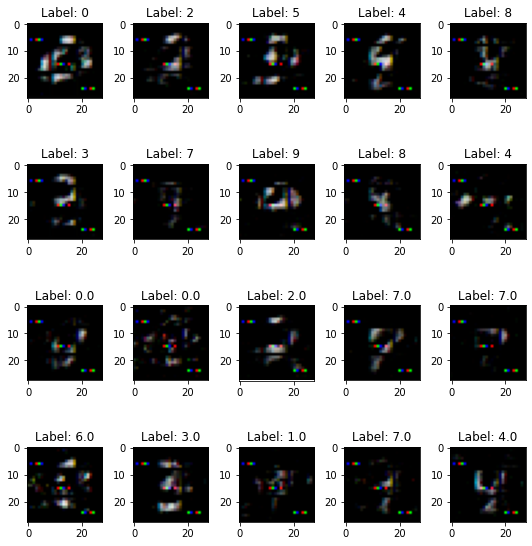

In [19]:
num_row = 4
num_col = 5
num = 10
images = source_reconstrueted[:num]
labels = source_label[:num]

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    image = images[i - 10].reshape(28,28,3)
    ax.imshow(image, cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))


images = target_reconstructed[:num]
labels = target_label[:num]
for i in range(10,20):
    ax = axes[i//num_col, i%num_col]
    image = images[i - 10].reshape(28,28,3)
    ax.imshow(image, cmap='gray')
    ax.set_title('Label: {}'.format(labels[i - 10]))
plt.tight_layout()
plt.show()

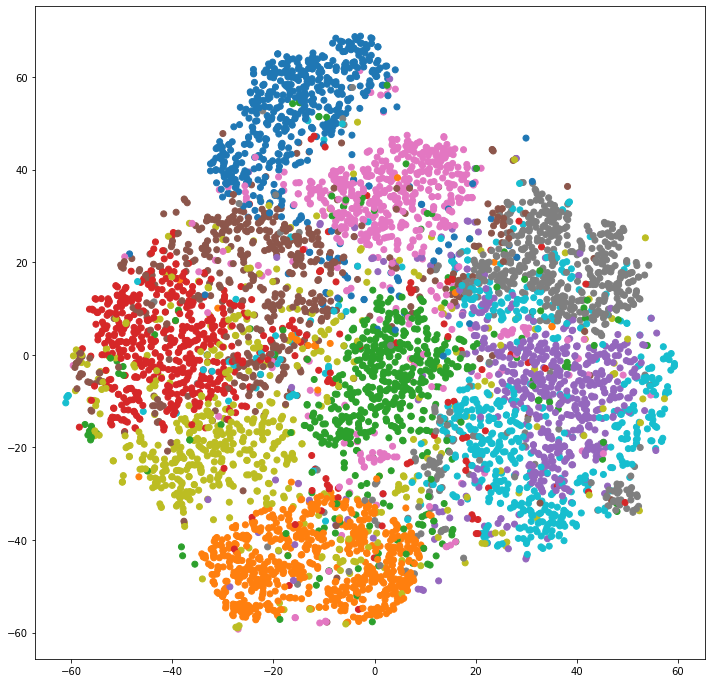

In [20]:
data_visualization.plot_info(source_tranformed_data, source_label, 2)

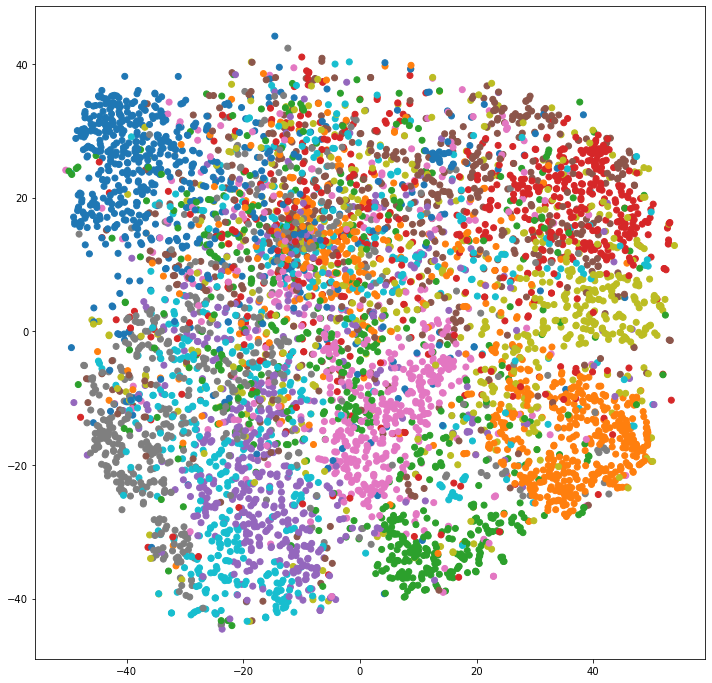

In [21]:
data_visualization.plot_info(target_tranformed_data, target_label, 2)

#### Use L1 loss as reconstruction loss

In [22]:
criterion = nn.CrossEntropyLoss()
criterion_construct = torch.nn.L1Loss()
net = DANN_with_autoencoder()

if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    net.cuda()
    criterion = criterion.cuda()
    criterion_construct = criterion_construct.cuda()
    
optimizer = optim.Adam(net.parameters(), lr=0.001) 


In [23]:
history_DAtuo_L1 = []
for epoch in range(0, 201):
    sl, sd, tl, td, total = train_with_autoencoder(loader_source, loader_target, net, criterion, criterion_construct, optimizer, True, epoch) 
    history_DAtuo_L1.append([sl/total, sd/total, tl/total, td/total])
    if (epoch % 20 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, sl/total, sd/total, tl/total, td/total))

e: 0, sl: 0.820833, sd: 0.802533, tl: 0.370183, td: 0.761667
e: 20, sl: 0.935400, sd: 0.688283, tl: 0.584783, td: 0.687633
e: 40, sl: 0.934367, sd: 0.653200, tl: 0.613883, td: 0.649517
e: 60, sl: 0.939417, sd: 0.638867, tl: 0.638350, td: 0.640800
e: 80, sl: 0.941300, sd: 0.629383, tl: 0.659100, td: 0.630367
e: 100, sl: 0.944567, sd: 0.629783, tl: 0.671150, td: 0.631183
e: 120, sl: 0.946233, sd: 0.624500, tl: 0.686283, td: 0.622317
e: 140, sl: 0.949317, sd: 0.627417, tl: 0.698000, td: 0.625967
e: 160, sl: 0.951633, sd: 0.624083, tl: 0.697150, td: 0.626900
e: 180, sl: 0.954383, sd: 0.623517, tl: 0.703533, td: 0.618150
e: 200, sl: 0.954483, sd: 0.621067, tl: 0.702967, td: 0.621817


In [24]:
source_reconstrueted, target_reconstructed, source_label, target_label = generate_image(net, loader_source, loader_target, 200)

source_tranformed_data = data_visualization.tsne(source_reconstrueted, 2, 0.1, type = "mnist")
target_tranformed_data = data_visualization.tsne(target_reconstructed, 2, 0.1, type = "mnist-m")

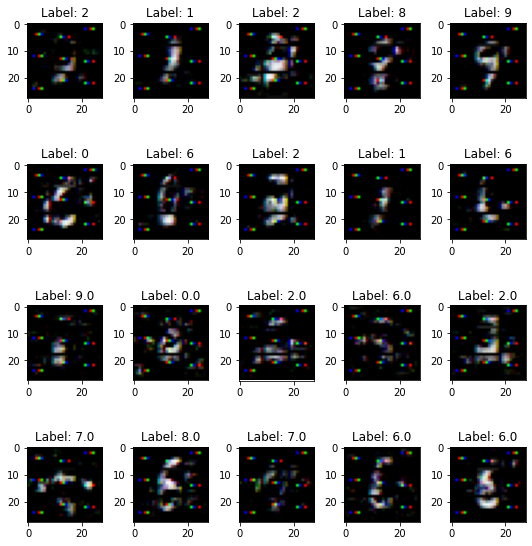

In [25]:
num_row = 4
num_col = 5
num = 10
images = source_reconstrueted[:num]
labels = source_label[:num]

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    image = images[i - 10].reshape(28,28,3)
    ax.imshow(image, cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))


images = target_reconstructed[:num]
labels = target_label[:num]
for i in range(10,20):
    ax = axes[i//num_col, i%num_col]
    image = images[i - 10].reshape(28,28,3)
    ax.imshow(image, cmap='gray')
    ax.set_title('Label: {}'.format(labels[i - 10]))
plt.tight_layout()
plt.show()

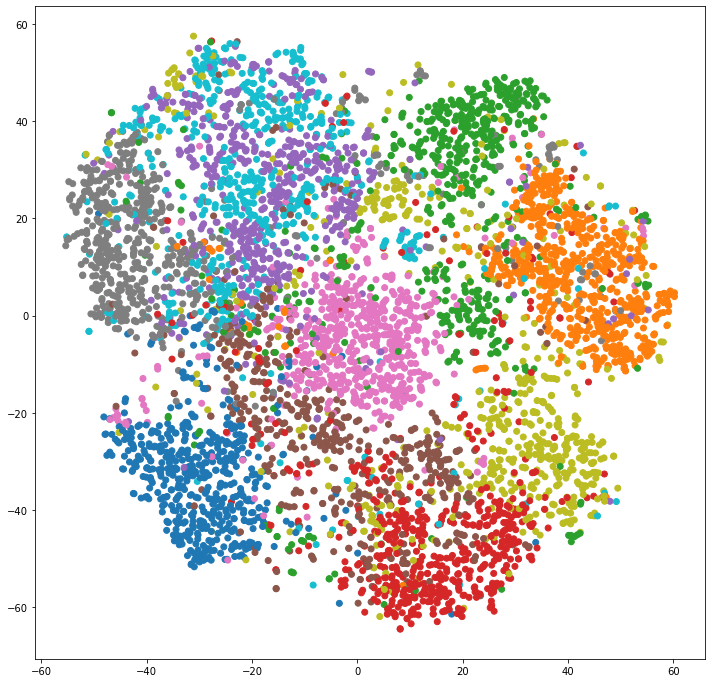

In [26]:
data_visualization.plot_info(source_tranformed_data, source_label, 2)

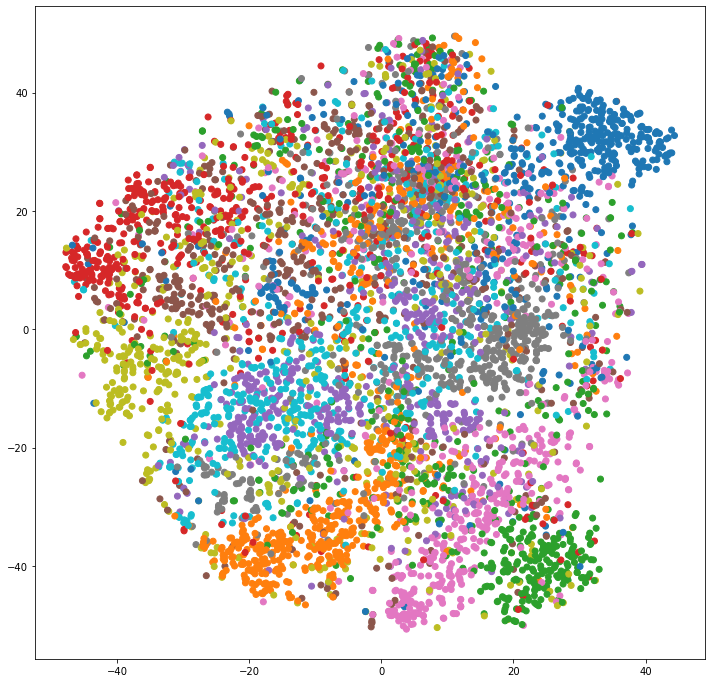

In [27]:
data_visualization.plot_info(target_tranformed_data, target_label, 2)

### Second Attempt: Add reconstrction loss between source reconstructed image and target reconstructed image

In [28]:
def train_with_autoencoder_v2(source, target, net, criterion,criterion_construct, optimizer, use_cuda, epoch):
    net.train() # Sets the module in training mode.
    total = 0
    data_target_iter = iter(target)

    correct_source_label = 0
    correct_source_domain = 0
    correct_target_label = 0
    correct_target_domain = 0

    len_dataloader = min(len(source), len(target))

    for batch_idx, (source_inputs, source_label) in enumerate(source):
        batch_size = source_inputs.size(0)
        total += batch_size
        optimizer.zero_grad()

        # Set alpha with respect to epoch number
        p = float(batch_idx + epoch * len_dataloader) / (200 * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # Specify the domain label and image label for Source
        source_label = source_label.type(torch.LongTensor)
        domain_label = torch.zeros(batch_size).long()

        if use_cuda: source_inputs, source_label, domain_label = source_inputs.cuda(), source_label.cuda(), domain_label.cuda()

        # Feed Source image into network
        source_inputs, source_label = Variable(source_inputs), Variable(source_label)
        class_output, domain_output, reconstruct_source = net(input_data=source_inputs, alpha=alpha)

        # Update the label classification accuracy and domain classification accuracy for Source image
        _, predicted = torch.max(class_output.data, 1)
        correct_source_label += predicted.eq(source_label.data).cpu().sum().item()

        _, predicted = torch.max(domain_output.data, 1)
        correct_source_domain += predicted.eq(domain_label.data).cpu().sum().item()

        # Calculate the loss of Source images
        loss_s_label = criterion(class_output, source_label)
        loss_s_domain = criterion(domain_output, domain_label)
        loss_construct_ss = criterion_construct(reconstruct_source, source_inputs)
        
        # Specify the domain label and image label for Target
        target_inputs, target_label = data_target_iter.next()
        domain_label = torch.ones(batch_size).long()
        if use_cuda: target_inputs, target_label, domain_label = target_inputs.cuda(), target_label.cuda(), domain_label.cuda()
        
        # Feed Target image into network
        target_inputs, target_label = Variable(target_inputs), Variable(target_label)
        class_output, domain_output, reconstruct_target = net(input_data=target_inputs, alpha=alpha)

        # Update the label classification accuracy and domain classification accuracy for Target image
        _, predicted = torch.max(class_output.data, 1)
        correct_target_label += predicted.eq(target_label.data).cpu().sum().item()

        _, predicted = torch.max(domain_output.data, 1)
        correct_target_domain += predicted.eq(domain_label.data).cpu().sum().item()

        # Calculate the loss of Target images
        loss_construct_tt = criterion_construct(reconstruct_target, target_inputs)
        loss_t_domain = criterion(domain_output, domain_label)

        loss_construct_ts = criterion_construct(reconstruct_target, reconstruct_source)

        loss = loss_s_label + loss_s_domain + loss_t_domain + loss_construct_tt + loss_construct_ts + loss_construct_ss

        loss.backward()
        optimizer.step()


    return correct_source_label, correct_source_domain, correct_target_label, correct_target_domain, total



In [29]:
criterion = nn.CrossEntropyLoss()
criterion_construct = torch.nn.L1Loss()
net = DANN_with_autoencoder()

if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    net.cuda()
    criterion = criterion.cuda()
    criterion_construct = criterion_construct.cuda()
    
optimizer = optim.Adam(net.parameters(), lr=0.001) 

In [32]:
history_DAtuo_v2 = []
for epoch in range(0, 201):
    sl, sd, tl, td, total = train_with_autoencoder_v2(loader_source, loader_target, net, criterion, criterion_construct, optimizer,True, epoch) 
    history_DAtuo_v2.append([sl/total, sd/total, tl/total, td/total])
    if (epoch % 20 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, sl/total, sd/total, tl/total, td/total))

e: 0, sl: 0.820967, sd: 0.776767, tl: 0.370433, td: 0.750567
e: 20, sl: 0.936783, sd: 0.677483, tl: 0.645850, td: 0.674550
e: 40, sl: 0.940033, sd: 0.645817, tl: 0.703267, td: 0.638867
e: 60, sl: 0.943233, sd: 0.632683, tl: 0.728433, td: 0.628817
e: 80, sl: 0.946733, sd: 0.623783, tl: 0.745117, td: 0.620867
e: 100, sl: 0.950283, sd: 0.624350, tl: 0.758567, td: 0.613500
e: 120, sl: 0.951867, sd: 0.621067, tl: 0.771417, td: 0.615217
e: 140, sl: 0.954183, sd: 0.614300, tl: 0.773700, td: 0.612517
e: 160, sl: 0.955200, sd: 0.616550, tl: 0.779183, td: 0.608983
e: 180, sl: 0.957667, sd: 0.616283, tl: 0.781750, td: 0.610850
e: 200, sl: 0.960017, sd: 0.616967, tl: 0.783683, td: 0.615783


In [33]:
source_reconstrueted, target_reconstructed, source_label, target_label = generate_image(net, loader_source, loader_target, 200)

source_tranformed_data = data_visualization.tsne(source_reconstrueted, 2, 0.1, type = "mnist")
target_tranformed_data = data_visualization.tsne(target_reconstructed, 2, 0.1, type = "mnist-m")

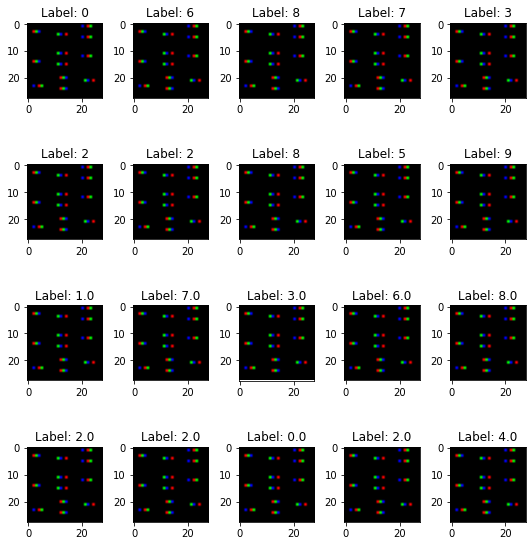

In [34]:
num_row = 4
num_col = 5
num = 10
images = source_reconstrueted[:num]
labels = source_label[:num]

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    image = images[i - 10].reshape(28,28,3)
    ax.imshow(image, cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))


images = target_reconstructed[:num]
labels = target_label[:num]
for i in range(10,20):
    ax = axes[i//num_col, i%num_col]
    image = images[i - 10].reshape(28,28,3)
    ax.imshow(image, cmap='gray')
    ax.set_title('Label: {}'.format(labels[i - 10]))
plt.tight_layout()
plt.show()

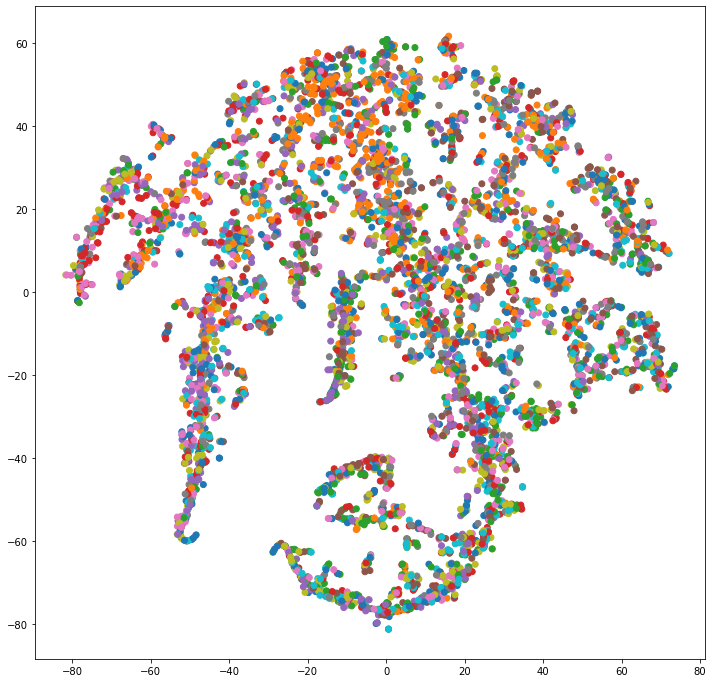

In [35]:
data_visualization.plot_info(source_tranformed_data, source_label, 2)

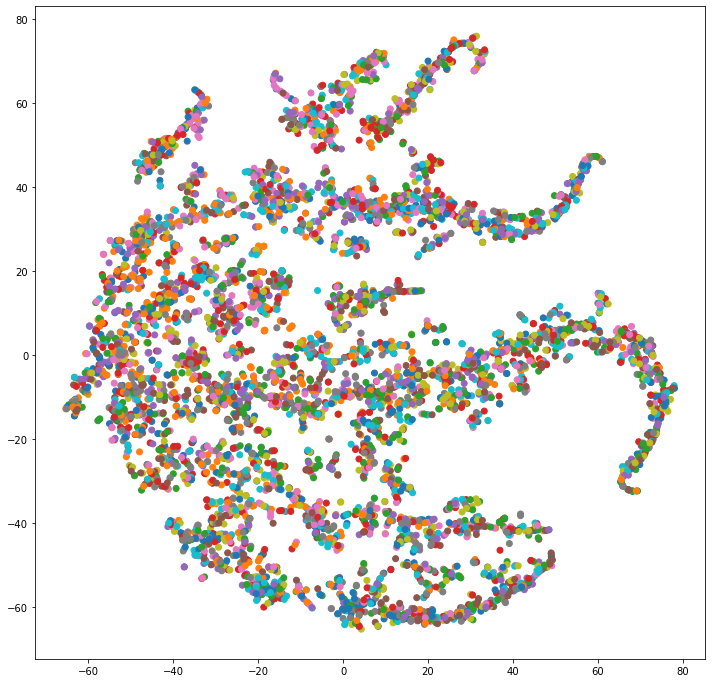

In [36]:
data_visualization.plot_info(target_tranformed_data, target_label, 2)

## Result

In [49]:
x = range(0, 201)
history_DANN = np.array(history_DANN)
history_DAtuo_L1 = np.array(history_DAtuo_L1)
history_DAtuo_L2 = np.array(history_DAtuo_L2)
history_DAtuo_v2 = np.array(history_DAtuo_v2)

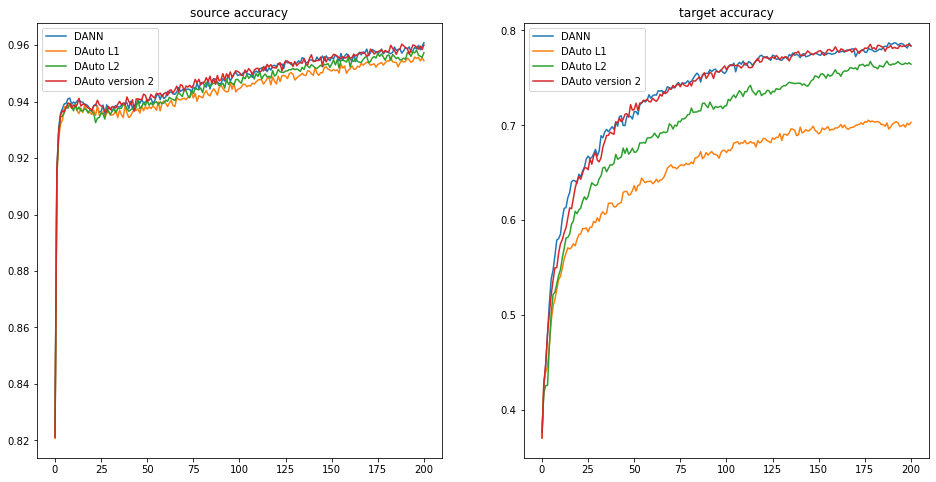

In [59]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 8))

ax1.plot(x, history_DANN[:,0])
ax1.plot(x, history_DAtuo_L1[:,0])
ax1.plot(x, history_DAtuo_L2[:,0])
ax1.plot(x, history_DAtuo_v2[:,0])
ax1.set_title("source accuracy")
ax1.legend(['DANN', 'DAuto L1', 'DAuto L2', 'DAuto version 2'])

ax2.plot(x, history_DANN[:,2])
ax2.plot(x, history_DAtuo_L1[:,2])
ax2.plot(x, history_DAtuo_L2[:,2])
ax2.plot(x, history_DAtuo_v2[:,2])
ax2.set_title("target accuracy")
ax2.legend(['DANN', 'DAuto L1', 'DAuto L2', 'DAuto version 2'])

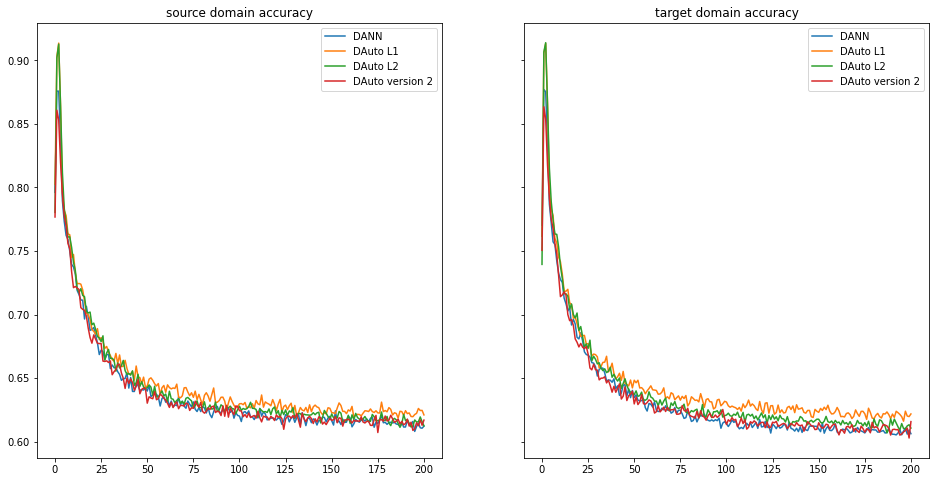

In [57]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(16, 8))

ax1.plot(x, history_DANN[:,1])
ax1.plot(x, history_DAtuo_L1[:,1])
ax1.plot(x, history_DAtuo_L2[:,1])
ax1.plot(x, history_DAtuo_v2[:,1])
ax1.set_title("source domain accuracy")
ax1.legend(['DANN', 'DAuto L1', 'DAuto L2', 'DAuto version 2'])

ax2.plot(x, history_DANN[:,3])
ax2.plot(x, history_DAtuo_L1[:,3])
ax2.plot(x, history_DAtuo_L2[:,3])
ax2.plot(x, history_DAtuo_v2[:,3])
ax2.set_title("target domain accuracy")
ax2.legend(['DANN', 'DAuto L1', 'DAuto L2', 'DAuto version 2'])